In [1]:
%run data.py

# Traffic Collison Data

### NYC Open Data: Motor Vehicle Collisions (Filter data: 2019.9.1 to today)

In [2]:
collison_url = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$select=crash_date,borough,zip_code,collision_id&$where=crash_date>'2019-09-01T00:00:00.000'&$limit=500000"
collison = pd.read_csv(collison_url)
collison.count()

crash_date      112291
borough          73202
zip_code         73184
collision_id    112291
dtype: int64

In [3]:
collison.head(10)

,crash_date,borough,zip_code,collision_id
0,2019-09-02T00:00:00.000,NaN,NaN,4198490
1,2019-09-02T00:00:00.000,MANHATTAN,10009.0,4198475
2,2019-09-02T00:00:00.000,NaN,NaN,4211490
3,2019-09-02T00:00:00.000,MANHATTAN,10026.0,4199231
4,2019-09-02T00:00:00.000,BROOKLYN,11218.0,4199309
5,2019-09-02T00:00:00.000,BRONX,10462.0,4198710
6,2019-09-02T00:00:00.000,BROOKLYN,11210.0,4198949
7,2019-09-02T00:00:00.000,MANHATTAN,10012.0,4199376
8,2019-09-02T00:00:00.000,BROOKLYN,11236.0,4200510
9,2019-09-02T00:00:00.000,QUEENS,11367.0,4198603


In [4]:
collison['zip_code'].fillna(0, inplace=True)
collisonpd = collison.astype({"crash_date":'datetime64[ns]', "borough":str, "zip_code":int, "collision_id":int})

In [5]:
collison_df = spark.createDataFrame(collisonpd)

In [6]:
collison_df.createOrReplaceTempView("collisonT")
collison = spark.sql("""
SELECT MONTH(crash_date) AS month,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY month
ORDER BY month
""")

collison = collison.withColumn("month_name", 
                                        f.when(f.col('month') == 1, "2020-01")\
                                        .when(f.col('month') == 2, "2020-02")\
                                        .when(f.col('month') == 3, "2020-03")\
                                        .when(f.col('month') == 4, "2020-04")\
                                        .when(f.col('month') == 5, "2020-05")\
                                        .when(f.col('month') == 9, "2019-09")\
                                        .when(f.col('month') == 10, "2019-10")\
                                        .when(f.col('month') == 11, "2019-11")\
                                        .when(f.col('month') == 12, "2019-12"))

### Average number of crash before Covid-19

In [8]:
#Covid-19 started in March 2020
average = collison.filter('month !=3 and month !=4 and month !=5').agg({"num_of_crash":"avg"})
avg_num = average.rdd.map(list)
avg= avg_num.take(1)[0][0]
print("Average number of car crashes before Covid-19: ", '%.2f' % avg)

Average number of car crashes before Covid-19:  16104.83


### Current month car crash number and falling rate

In [9]:
collison.createOrReplaceTempView("latestT")
latest = spark.sql("SELECT num_of_crash FROM latestT WHERE month_name = \
                                     (SELECT max(month_name) FROM  latestT)")
latest = latest.rdd.map(list)
latest = latest.take(1)[0][0]
falling_rate = '%.2f' % ((avg - latest)/ avg*100)+"%"
print("Current month number of car crashes: ",'%.2f' %latest)
print("Car carsh falling rate: ", falling_rate)

Current month number of car crashes:  612.00
Car carsh falling rate:  96.20%


In [10]:
collisonpd = collison.select("month_name","num_of_crash").orderBy("month_name").toPandas()
collisonpd

,month_name,num_of_crash
0,2019-09,17067
1,2019-10,17609
2,2019-11,16950
3,2019-12,17056
4,2020-01,14276
5,2020-02,13671
6,2020-03,11020
7,2020-04,4030
8,2020-05,612


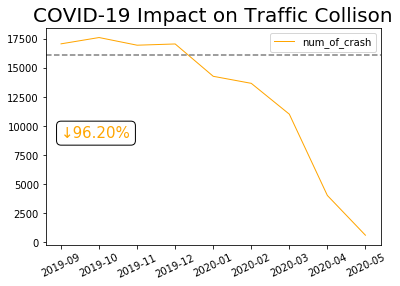

In [19]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot('month_name','num_of_crash', data=collisonpd, marker='', color='orange', linewidth=1)
plt.title('COVID-19 Impact on Traffic Collison',fontsize = 20)

rate = "↓" + falling_rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 9000, rate, size = 15, color = "orange", bbox=bbox_props)

plt.axhline(y = avg,ls = "dashed",color = "grey") 

plt.xticks( rotation=25 )
plt.rcParams['figure.figsize'] = (10,5)
plt.legend()

### Car crash vs Covid-19 cases (by borough)

Car crash by borough

In [15]:
collison_borough = spark.sql("""
SELECT borough,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY borough
ORDER BY num_of_crash desc
""")

In [16]:
from pyspark.sql.functions import col
df = collison_borough.withColumn("borough",
    f.when(collison_borough["borough"]=='nan','unknown').when(collison_borough["borough"]=='STATEN ISLAND','staten_island').
    otherwise(collison_borough["borough"]))
df=df.withColumn("borough",f.lower(f.col("borough")))
collison = df.toPandas()

Covid-19 cases by borough

In [17]:
cov = fetchData(nyc_his_boro_url)
cov = cov.drop(columns = ['timestamp','total'])
cov2 = cov.loc[cov['type']=='cases']
cov2 = cov2.tail(1)
cov2.set_index(["type"], inplace = True) 

cov2 = cov2.stack()
cov = cov2.unstack(0)
cov['borough']=cov.index

merge

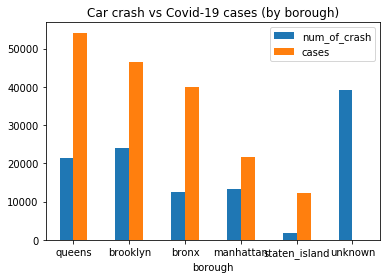

In [18]:
res = pd.merge(collison,cov, on='borough')
res = res.sort_values(by='cases',ascending=False)
res.set_index(["borough"], inplace = True) 
res.plot.bar(rot=0,title="Car crash vs Covid-19 cases (by borough)")